In [36]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import numpy as np


In [37]:
SEED = 42
random.seed(SEED)
numpy_seed = SEED
np.random.seed(numpy_seed)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmar = False

In [53]:
train_img_dir = "images/ISIC-2017_Training_Data"
val_img_dir = "images/ISIC-2017_Validation_Data"
test_img_dir = "images/ISIC-2017_Test_v2_Data"

train_csv = 'images/ISIC-2017_Training_Part3_GroundTruth.csv'
val_csv = 'images/ISIC-2017_Validation_Part3_GroundTruth.csv'
test_csv = 'images/ISIC-2017_Test_v2_Part3_GroundTruth.csv'

batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_sample_size = 400

In [54]:
pd.read_csv(test_csv)

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0012086,0.0,1.0
1,ISIC_0012092,0.0,0.0
2,ISIC_0012095,0.0,0.0
3,ISIC_0012134,0.0,1.0
4,ISIC_0012136,0.0,1.0
...,...,...,...
595,ISIC_0016068,0.0,0.0
596,ISIC_0016069,0.0,0.0
597,ISIC_0016070,0.0,0.0
598,ISIC_0016071,0.0,0.0


In [55]:
def create_transforms():
    train_t = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229, 0.224, 0.225]
     )
    ])

    val_t = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

    return train_t, val_t



In [56]:
def make_loader(csv_path, img_dir, transform, shuffle=False, sample_size=None):
    df = pd.read_csv(csv_path)
    if sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    imgs, labels = [], []
    for _, row in df.iterrows():
        img_id = str(row.iloc[0])
        label = int(row.iloc[1])
        for ext in ('.jpg', '.jpeg'):
            path = os.path.join(img_dir, img_id + ext)
            if os.path.exists(path):
                img = Image.open(path).convert('RGB')
                break

        else:
            raise FileNotFoundError(f'no image for id: {img_id} in {img_dir}')
        imgs.append(transform(img))
        labels.append(label)
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels,dtype=torch.long)
    return DataLoader(TensorDataset(imgs_tensor, labels_tensor), batch_size=batch_size, shuffle=shuffle)





In [57]:
train_transform, val_transform = create_transforms()
train_loader = make_loader(train_csv, train_img_dir, train_transform, shuffle=True, sample_size=train_sample_size)
val_loader = make_loader(val_csv, val_img_dir, val_transform, shuffle=False, sample_size=None)
test_loader = make_loader(test_csv, test_img_dir, val_transform)

In [58]:
all_labels = []
for _, y in val_loader:
    all_labels.extend(y.tolist())
print("Labels in val_loader:", sorted(set(all_labels)),
      "counts:", {cls: all_labels.count(cls) for cls in set(all_labels)})


Labels in val_loader: [0, 1] counts: {0: 120, 1: 30}


In [59]:
pd.read_csv(train_csv).sample(n=train_sample_size, random_state=42)

,image_id,melanoma,seborrheic_keratosis
1860,ISIC_0014650,0.0,1.0
353,ISIC_0000434,1.0,0.0
1333,ISIC_0013012,0.0,0.0
905,ISIC_0010602,0.0,0.0
1289,ISIC_0012877,0.0,0.0
...,...,...,...
965,ISIC_0011158,1.0,0.0
1284,ISIC_0012855,0.0,0.0
1739,ISIC_0014249,1.0,0.0
261,ISIC_0000313,1.0,0.0


In [60]:
df_sub = pd.read_csv(train_csv).sample(n=train_sample_size, random_state=42)
freq  = df_sub.iloc[:,1].value_counts().sort_index()
weights = torch.tensor([freq.max()/freq[i] for i in freq.index], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

In [61]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
best_auc, epochs_no_improve, patience = 0.0, 0, 3


In [62]:
import pandas as pd

df_val = pd.read_csv(val_csv)
print("Validation set label counts:\n", df_val.iloc[:,1].value_counts())


Validation set label counts:
 melanoma
0.0    120
1.0     30
Name: count, dtype: int64


In [63]:
val_auc_history = []
best_auc =  0.0
for epoch in range(1,21):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out =  model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    model.eval()
    probs, labs =[], []
    with torch.no_grad():
        for X, y in val_loader:

            p = torch.softmax(model(X.to(device)), dim=1)[:,1].cpu()
            probs.extend(p.tolist())
            labs.extend(y.tolist())

    auc = roc_auc_score(labs, probs)
    val_auc_history.append(auc)
    print(f'epoch {epoch} - val auc: {auc:.4f}')

    if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), 'best_model.pt')

    else:
        epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('early stopping triggered')
            break

    scheduler.step()




epoch 1 - val auc: 0.7347
epoch 2 - val auc: 0.6842
epoch 3 - val auc: 0.6764
epoch 4 - val auc: 0.6794
early stopping triggered


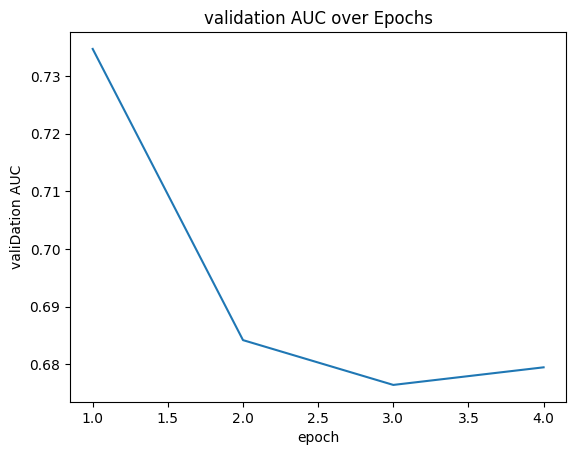

<All keys matched successfully>

In [64]:
plt.figure()
plt.plot(range(1, len(val_auc_history)+1), val_auc_history)
plt.xlabel('epoch')
plt.ylabel('valiDation AUC')
plt.title('validation AUC over Epochs')
plt.show()

model.load_state_dict(torch.load('best_model.pt'))

In [65]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
probs, labs = [], []
with torch.no_grad():
    for X, y in test_loader:
        p = torch.softmax(model(X.to(device)), dim=1)[:,1].cpu()
        probs.extend(p.tolist());labs.extend(y.tolist())
preds = [1 if p>=0.5 else 0 for p in probs]

In [66]:
print('Test AUC:', roc_auc_score(labs, probs))
print('accuracy:', accuracy_score(labs, preds))
tn, fp, fn, tp = confusion_matrix(labs, preds).ravel()
print('sensitivity:', tp/(tp+fn), 'specificity:', tn/(tn+fp))


Test AUC: 0.6428482950222081
accuracy: 0.8016666666666666
sensitivity: 0.1282051282051282 specificity: 0.9648033126293996


In [67]:
print(classification_report(labs, preds, target_names=['non-melanoma', 'melanoma']))

              precision    recall  f1-score   support

non-melanoma       0.82      0.96      0.89       483
    melanoma       0.47      0.13      0.20       117

    accuracy                           0.80       600
   macro avg       0.64      0.55      0.54       600
weighted avg       0.75      0.80      0.75       600

